# In this Notebook we are attempting to predict a persons next N fights

## Library Imports

In [5]:
import sys
sys.path.insert(1, '../combined_data')
sys.path.insert(1, '../predict_winner')
from make_career import make_career
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import talos as ta
from talos.model.normalizers import lr_normalizer
from talos.model.hidden_layers import hidden_layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

## Loading the dataset

In [6]:
features, labels = make_career(N_FIGHT_CAREER=10, N_FUTURE_LABELS=5)
labels = encode_all_labels()

Creating careers using 10 fight intervals and predicting 5 future fights
Original fight data shape: (5062, 153)
Fights 2x shape: (10124, 95)

Features shape: (600, 10)
Labels shape: (600, 5)

Features is a 2D matrix with 600 rows
Each row contains has 10 fights, and each fight has 100 keys

Labels is a 2D matrix with 600 rows
Each row contains the the prediction for the next 5 fight(s)


In [7]:
print(features.shape)
print(type(features))

(600, 10)
<class 'numpy.ndarray'>


In [8]:
print(labels.shape)
print(type(labels))

(600, 5)
<class 'numpy.ndarray'>


## Preprocess Features

## Generates np.array of shape (3220, 5 * features)

In [9]:
from sklearn.utils import shuffle

def collapse_n_fights():
    num_cols, cat_cols = get_column_types()
    
    # Collect only the features we want
    new_features = []
    for window in features:
        window_arr = list(window.reshape(1,-1))[0]
        fight_window = np.array([])
        for fight in window_arr:
            fight_arr = np.array([fight[i] for i in num_cols])
            np.nan_to_num(fight_arr, copy=False)
            fight_window = np.append(fight_window, fight_arr)
        new_features.append(fight_window)
    
    new_features, new_labels = shuffle(np.array(new_features), labels)
    X_train, X_test, y_train, y_test = train_test_split(new_features, new_labels, random_state=0, train_size=0.99)
    
    # Scale the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    print("X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
    print("X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))
    
    return X_train, X_test, y_train, y_test

## Building a CNN to predict the winner using last n fights

In [10]:
# Get the data
X_train, X_test, y_train, y_test = collapse_n_fights()
X_train = X_train.reshape(X_train.shape[0], 10, 97)
X_test = X_test.reshape(X_test.shape[0], 10, 97)

print("New: X_train length {}, y_train length {}".format(X_train.shape, y_train.shape))
print("New: X_test length {}, y_test length {}".format(X_test.shape, y_test.shape))

y_train = np.array(convert_labels(y_train))
y_test = np.array(convert_labels(y_test))
print(y_train[0].shape)
print(y_train.shape)

X_train length (594, 970), y_train length (594, 5)
X_test length (6, 970), y_test length (6, 5)
New: X_train length (594, 10, 97), y_train length (594, 5)
New: X_test length (6, 10, 97), y_test length (6, 5)
(594,)
(5, 594)


In [11]:
model = get_ensemble()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 10, 97)       0                                            
__________________________________________________________________________________________________
Conv_1D (Conv1D)                (None, 9, 128)       24960       Input[0][0]                      
__________________________________________________________________________________________________
Dropout (Dropout)               (None, 9, 128)       0           Conv_1D[0][0]                    
__________________________________________________________________________________________________
Flatten (Flatten)               (None, 1152)         0           Dropout[0][0]                    
____________________________________________________________________________________________

In [12]:
history = model.fit(X_train,
                    {'Fight_1': y_train[0], 
                     'Fight_2': y_train[1], 
                     'Fight_3': y_train[2], 
                     'Fight_4': y_train[3],
                     'Fight_5': y_train[4],},
                   validation_split=0.2,
                   batch_size=32,
                   epochs=10,
                   verbose=1)

Train on 475 samples, validate on 119 samples
Epoch 1/10
475/475 [==============================] - 0s 997us/step - loss: 3.7923 - Fight_1_loss: 0.7026 - Fight_2_loss: 0.7607 - Fight_3_loss: 0.7214 - Fight_4_loss: 0.7945 - Fight_5_loss: 0.8092 - Fight_1_accuracy: 0.5663 - Fight_2_accuracy: 0.5368 - Fight_3_accuracy: 0.5284 - Fight_4_accuracy: 0.5074 - Fight_5_accuracy: 0.4821 - val_loss: 3.6253 - val_Fight_1_loss: 0.8236 - val_Fight_2_loss: 0.6851 - val_Fight_3_loss: 0.6839 - val_Fight_4_loss: 0.6961 - val_Fight_5_loss: 0.7317 - val_Fight_1_accuracy: 0.5210 - val_Fight_2_accuracy: 0.5546 - val_Fight_3_accuracy: 0.5546 - val_Fight_4_accuracy: 0.5378 - val_Fight_5_accuracy: 0.4874
Epoch 2/10
475/475 [==============================] - 0s 226us/step - loss: 3.0541 - Fight_1_loss: 0.5853 - Fight_2_loss: 0.5926 - Fight_3_loss: 0.6034 - Fight_4_loss: 0.6335 - Fight_5_loss: 0.6383 - Fight_1_accuracy: 0.6947 - Fight_2_accuracy: 0.6968 - Fight_3_accuracy: 0.6779 - Fight_4_accuracy: 0.6421 - Figh

In [13]:
def plot_training_results():

    acc_1 = history.history['Fight_1_accuracy']
    acc_2 = history.history['Fight_2_accuracy']
    acc_3 = history.history['Fight_3_accuracy']
    acc_4 = history.history['Fight_4_accuracy']
    acc_5 = history.history['Fight_5_accuracy']
    
    val_acc_1 = history.history['val_Fight_1_accuracy']
    val_acc_2 = history.history['val_Fight_2_accuracy']
    val_acc_3 = history.history['val_Fight_3_accuracy']
    val_acc_4 = history.history['val_Fight_4_accuracy']
    val_acc_5 = history.history['val_Fight_5_accuracy']
    
    epochs = range(1, len(acc_1) + 1)

    fig, (accuracy_axis, training_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc_1, 'b', label='Fight 1 Acc')
    accuracy_axis.plot(epochs, acc_2, 'g', label='Fight 2 Acc')
    accuracy_axis.plot(epochs, acc_3, 'r', label='Fight 3 Acc')
    accuracy_axis.plot(epochs, acc_4, 'c', label='Fight 4 Acc')
    accuracy_axis.plot(epochs, acc_5, 'm', label='Fight 5 Acc')
    accuracy_axis.set_title('Training Set Accuracy over time')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()
    
    training_axis.plot(epochs, val_acc_1, 'b', label='Fight 1 Acc')
    training_axis.plot(epochs, val_acc_2, 'g', label='Fight 2 Acc')
    training_axis.plot(epochs, val_acc_3, 'r', label='Fight 3 Acc')
    training_axis.plot(epochs, val_acc_4, 'c', label='Fight 4 Acc')
    training_axis.plot(epochs, val_acc_5, 'm', label='Fight 5 Acc')
    training_axis.set_title('Test Set Accuracy over time')
    training_axis.set_ylabel('Accuracy')
    training_axis.set_xlabel('Epoch')
    training_axis.legend()
    fig.show()

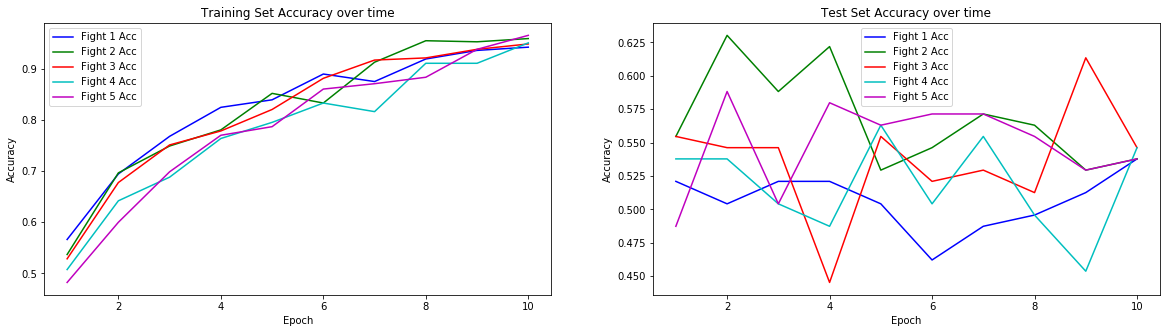

In [14]:
plot_training_results()

In [15]:
# fig = plt.figure(figsize=(20, 6))
# ax = fig.add_subplot(1,2,1)
# w = 0.35
# dnn = [0.90, 0.90, 0.90]
# for s, c, offset in [('accuracy', 'g', -w/4), ('f1_score', 'r', w/4)]:
#     filtered = grouped[grouped['season'] == s]
#     ax.bar(filtered['release_year']+offset, filtered['rating'], color=c, label=s, width=w/4)

# ax.legend();

# Model Builders

### Build a multi-output model
### Bottom is a CNN, Top is 5 DNNs

In [16]:
# Model imports
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D, LSTM, Input
from keras.optimizers import Adam, Nadam, RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid

In [17]:
def get_ensemble():
    # x_train, y_train, x_val, y_val, params, test_model=False
    fight_input = Input(shape=(10, 97), name="Input")
    x = Conv1D(filters=128, kernel_size=2, activation='relu', name="Conv_1D")(fight_input)
    x = Dropout(0.01, name="Dropout")(x)
    x = Flatten(name="Flatten")(x)

    # Global Dense Network
    x = Dense(128, activation='relu', name="Global_Dense")(x)

    # 5 output layers
    fight_1 = Dense(1, activation='sigmoid', name="Fight_1")(x)
    fight_2 = Dense(1, activation='sigmoid', name="Fight_2")(x)
    fight_3 = Dense(1, activation='sigmoid', name="Fight_3")(x)
    fight_4 = Dense(1, activation='sigmoid', name="Fight_4")(x)
    fight_5 = Dense(1, activation='sigmoid', name="Fight_5")(x)

    model = Model(inputs=fight_input,
                  outputs=[fight_1, fight_2, fight_3, fight_4, fight_5])
    
    model.compile(optimizer='rmsprop',
                 loss={"Fight_1": "binary_crossentropy", 
                       "Fight_2": "binary_crossentropy",
                       "Fight_3": "binary_crossentropy",
                       "Fight_4": "binary_crossentropy",
                       "Fight_5": "binary_crossentropy"},
                 loss_weights={"Fight_1": 1., 
                               "Fight_2": 1.,
                               "Fight_3": 1.,
                               "Fight_4": 1.,
                               "Fight_5": 1.},
                 metrics={"Fight_1": "accuracy", 
                          "Fight_2": "accuracy",
                          "Fight_3": "accuracy",
                          "Fight_4": "accuracy",
                          "Fight_5": "accuracy"})

    model.summary()
    return model

## Helper Functions

## Extract numerical and categorical columns

In [18]:
# Get the first fight window and the first fight in that window
def get_column_types():
    num_cols = []
    cat_cols = []
    for fight in features[0][0]:
        feature_type = type(features[1][1][fight])
        if feature_type is not float and feature_type is not int:
            cat_cols.append(fight)
        else:
            num_cols.append(fight)
            
    return num_cols, cat_cols


def plot_training_results(history_obj):
    acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']
    loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    epochs = range(1, len(acc) + 1)

    fig, (accuracy_axis, loss_axis) = plt.subplots(1, 2, figsize=(20, 5))

    accuracy_axis.plot(epochs, acc, 'bo', label='Training acc')
    accuracy_axis.plot(epochs, val_acc, 'b', label='Validation acc')
    accuracy_axis.set_title('Training and validation accuracy')
    accuracy_axis.set_ylabel('Accuracy')
    accuracy_axis.set_xlabel('Epoch')
    accuracy_axis.legend()

    loss_axis.plot(epochs, loss, 'bo', label='Training loss')
    loss_axis.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_axis.set_title('Training and validation loss')
    loss_axis.set_ylim(0, 3)
    loss_axis.set_ylabel('Loss')
    loss_axis.set_xlabel('Epoch')
    loss_axis.legend()
    fig.show()


def encode_all_labels():
    encoded_labels = []
    for row in labels:
        new_labels_list = []
        for elem in row:
            if elem:
                new_labels_list.append(1)
            else:
                new_labels_list.append(0)
        encoded_labels.append(new_labels_list)
    encoded_labels = np.array(encoded_labels)
    
    return encoded_labels


def convert_labels(y_train):  
    fights_1 = np.array(y_train[:,0])
    fights_2 = np.array(y_train[:,1])
    fights_3 = np.array(y_train[:,2])
    fights_4 = np.array(y_train[:,3])
    fights_5 = np.array(y_train[:,4])
    
    y_train = [fights_1, fights_2, fights_3, fights_4, fights_5]
    
    return y_train

In [19]:
x, y = get_column_types()

Text(0.5, 0, 'Model Type')

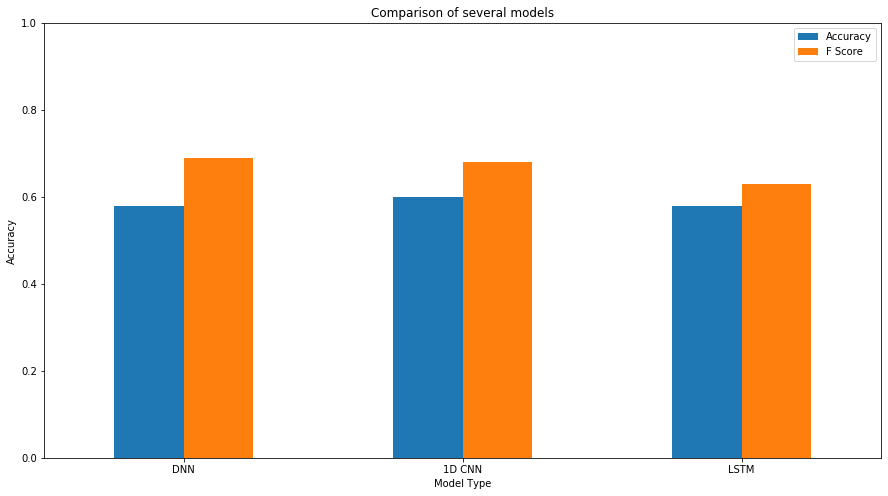

In [20]:
acc = [0.58, 0.60, 0.58]
f1 = [0.69, 0.68, 0.63]
index = ['DNN', '1D CNN', "LSTM"]
df = pd.DataFrame({'Accuracy': acc,
                   'F Score': f1}, index=index)
ax = df.plot.bar(rot=0, figsize=(15,8))
ax.set_ylim(0,1)
ax.set_title("Comparison of several models")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model Type")

Text(0.5, 0, 'Model Type')

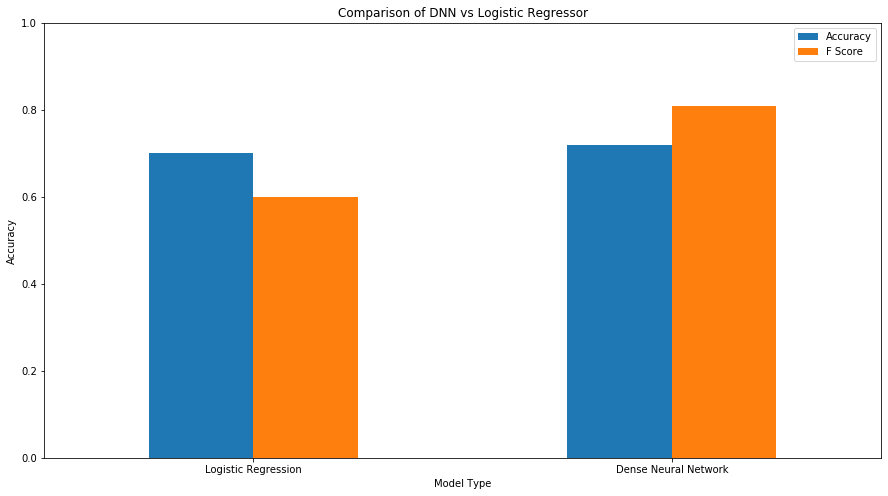

In [21]:
acc = [0.7, 0.72]
f1 = [0.6, 0.81]
index = ['Logistic Regression', 'Dense Neural Network']
df = pd.DataFrame({'Accuracy': acc,
                   'F Score': f1}, index=index)
ax = df.plot.bar(rot=0, figsize=(15,8))
ax.set_ylim(0,1)
ax.set_title("Comparison of DNN vs Logistic Regressor")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model Type")